# Dataset
* Number of train samples: 220025
* Number of test samples: 57458
* Image size: 96 * 96 * 3

The task is binary class classificatoin, and our goal is to train a model that can read the medical images and distinguish positive cases from negatives.

# EDA
All images are the same shape, and there are no duplicates. They are ready to be used for training. 

# Model structure
The train dataset is large, so we can use a slightly more complex model.  I built a CNN model with various types of layers, such as Conv2D, MaxPooling, Dropout ... and finally a Dense layer for classification. 

# Results
Our model learned sufficiently after the first epoch but encountered overfitting issues as the training continued. 

# Discussions
Pre-trained models specifically trained for medical images should have much beter results than the naive model in this notebook. Unfortunately, under the scope of this project, I did not investigate those possibilities. 

In [1]:
import numpy as np 
import pandas as pd 
from glob import glob 
from skimage.io import imread 
import os
import matplotlib.pyplot as plt
import pickle

# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

# Model Architecture
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [2]:
# Filter a few samples for debugging purposes
DEBUG = True
SUBSET = True

In [3]:
# List of paths of sample images
working_dir = '/kaggle/input/histopathologic-cancer-detection'

files = os.listdir(working_dir + '/train')

print('Number of images in the dataset: ', len(files))

# Load train labels
train_labels = working_dir + '/train_labels.csv'
tl = pd.read_csv(train_labels)

# Filter sample images from tl
fid = [file.split('.')[0] for file in files]
tl = tl[tl['id'].isin(fid)]

# Add path to tl
tl['path'] = tl['id'].apply(lambda x: working_dir + '/train/' + x + '.tif')

# Add img_arr to tl
if DEBUG:
    print('Sampleing 20 rows for debuging purposes.')
    tl = tl.sample(20)
    
elif SUBSET:
    print('Sampleing 30000 rows for faster training.')
    tl = tl.sample(30000)

tl['img_arr'] = tl['path'].apply(lambda x: imread(x))

# Show one imr_arr for example
print('Show one imr_arr for example:', tl['img_arr'].iloc[0].shape)

Number of images in the dataset:  220025
Sampleing 20 rows for debuging purposes.
Show one imr_arr for example: (96, 96, 3)


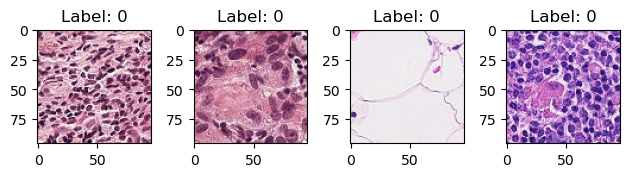

In [4]:
# Plot 4 images for demonstration
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(tl['img_arr'].iloc[i])
    title = 'Label: {}'.format(tl['label'].iloc[i])
    plt.title(title)

plt.tight_layout()

In [5]:
# Concat images 
input_images = np.stack(tl['img_arr'].to_list(), axis=0)
print(input_images.shape)

(20, 96, 96, 3)


In [6]:
# Prepare dataset for training
lb = LabelBinarizer()
y = lb.fit_transform(tl['label'])
print('Show y shape')
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(input_images, y, test_size=0.1, random_state=2023)

# Show data shapes
print('Show data shapes: X_train, X_val ... etc')
for item in X_train,X_test, y_train, y_test:
    print(item.shape)

Show y shape
(20, 1)
Show data shapes: X_train, X_val ... etc
(18, 96, 96, 3)
(2, 96, 96, 3)
(18, 1)
(2, 1)


In [7]:
# Model architecture
model = Sequential()

# Feature extraction
model.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(96,96,3)))
model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(2))
model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(2))
model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(2))
model.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
model.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
model.add(Flatten())

# Classifer
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Comiler
optimizer = Adam()
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

model_path = '/kaggle/working/model.h5'
checkpointer = ModelCheckpoint(filepath=model_path, 
                               verbose=1, 
                               save_best_only=True, 
                               monitor='val_loss')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 32)        9248      
                                                                 
 dropout (Dropout)           (None, 92, 92, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 42, 42, 64)        36928     
                                                        

In [8]:
# training
epochs = 10
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_test, y_test),
                    epochs=epochs,
                    batch_size=None,
                    callbacks=[early_stopping, checkpointer],
                    verbose=1)

Epoch 1/10
1/1 [==============================] - ETA: 0s - loss: 5.3672 - accuracy: 0.5556
Epoch 1: val_loss improved from inf to 0.00000, saving model to /kaggle/working/model.h5
1/1 [==============================] - 2s 2s/step - loss: 5.3672 - accuracy: 0.5556 - val_loss: 2.4449e-27 - val_accuracy: 1.0000
Epoch 2/10
1/1 [==============================] - ETA: 0s - loss: 100.5926 - accuracy: 0.4444
Epoch 2: val_loss did not improve from 0.00000
1/1 [==============================] - 1s 827ms/step - loss: 100.5926 - accuracy: 0.4444 - val_loss: 0.2066 - val_accuracy: 1.0000
Epoch 3/10
1/1 [==============================] - ETA: 0s - loss: 2.5116 - accuracy: 0.4444
Epoch 3: val_loss did not improve from 0.00000
1/1 [==============================] - 1s 806ms/step - loss: 2.5116 - accuracy: 0.4444 - val_loss: 2.1726 - val_accuracy: 0.0000e+00
Epoch 4/10
1/1 [==============================] - ETA: 0s - loss: 2.5068 - accuracy: 0.5556
Epoch 4: val_loss did not improve from 0.00000
1/1 [=

Text(0.5, 1.0, 'accuracy')

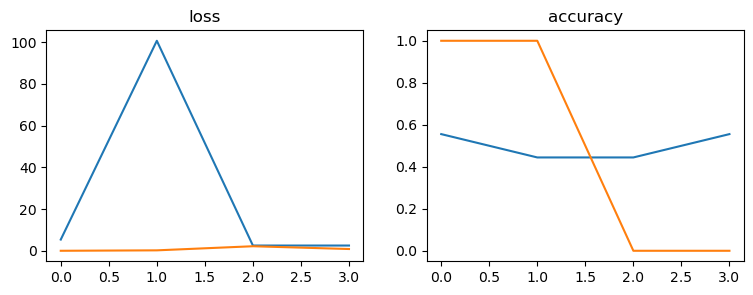

In [9]:
# Show results
plt.figure(figsize=(9,3))

plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('accuracy')

In [10]:
# Load model for prediciton
model.load_weights(model_path)

In [11]:
# Making submission
ss = working_dir + '/sample_submission.csv'
ss = pd.read_csv(ss)
ss['path'] = ss['id'].apply(lambda x: working_dir + '/test/' + x + '.tif')

# Filter a few samples for debugging purposes
if DEBUG:
    print('Sampleing 20 rows for debuging purposes.')
    ss = ss.sample(20)
    
# Generate image array and stack
test_img_arr = ss['path'].apply(lambda x: imread(x))
test_img_arr = np.stack(test_img_arr, axis=0)

# Making predictions and clean up submission file
preds = model.predict(test_img_arr)
ss = ss.drop(columns='path')
ss['label'] = preds

# Save submission
ss.to_csv("submission.csv", index=False)

Sampleing 20 rows for debuging purposes.
1/1 [==============================] - 0s 318ms/step
